<a href="https://colab.research.google.com/github/zhcgreat/zhc/blob/main/13_b_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistics (b)

## Bayesian Regression

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
plt.style.use('seaborn')
plt.rc('font',family='serif')
np.random.seed(1000)
%matplotlib inline

In [3]:
import arviz as az
az.style.use("arviz-darkgrid")

### Introductory Example

In [ ]:
x = np.linspace(0, 10, 500)
y = 4 + 2 * x + np.random.standard_normal(len(x)) * 2

In [ ]:
reg = np.polyfit(x, y, 1)

In [ ]:
reg

array([2.03384161, 3.77649234])

Text(0, 0.5, 'y')

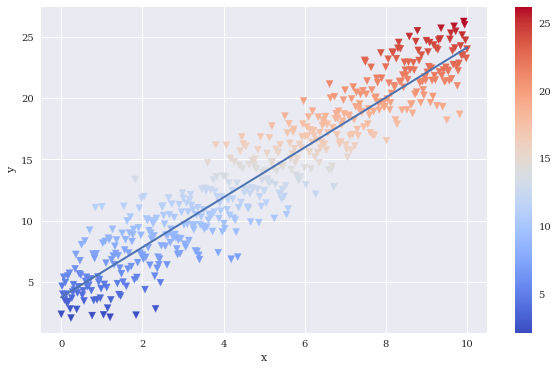

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.plot(x, reg[1] + reg[0] * x, lw=2.0)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
# plt.savefig('../../images/ch13/stat_15.png');

In [ ]:
import warnings; warnings.simplefilter('ignore')

In [5]:
import pymc3 as pm

In [ ]:
%%time
with pm.Model() as model:
    # model
    alpha = pm.Normal('alpha', mu=0, sigma=20)  # Defines the priors
    beta = pm.Normal('beta', mu=0, sigma=10)  # Defines the priors 
    sigma = pm.Uniform('sigma', lower=0, upper=10)  # Defines the priors
    y_est = alpha + beta * x    # Specifies the linear regression
    likelihood = pm.Normal('y', mu=y_est, sigma=sigma,
                           observed=y)   # Defines the likelihood.
    
    # inference
    start = pm.find_MAP()    # Finds the starting value by optimization.
    step = pm.NUTS()    #  Instantiates the MCMC algorithm.
    trace = pm.sample(100, tune=1000, start=start, progressbar=True)  #  Instantiates the MCMC algorithm.


NameError: name 'x' is not defined

In [ ]:
pm.summary(trace)   # Shows summary statistics from samplings.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.785,0.153,3.526,4.070,0.012,0.009,163.0,181.0,1.08
beta,2.035,0.027,1.990,2.087,0.002,0.002,149.0,170.0,1.05
sigma,2.011,0.055,1.913,2.123,0.007,0.005,58.0,108.0,1.05


In [ ]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
trace.posterior['alpha'][0].values[0]

4.113784025680294

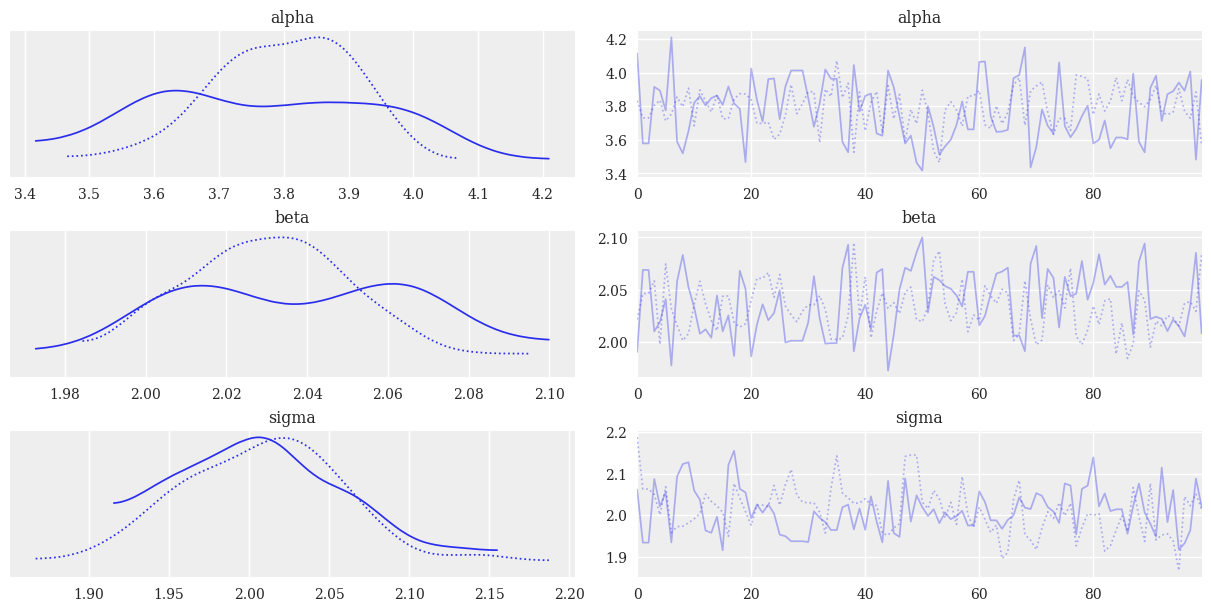

In [ ]:
az.plot_trace(trace);
plt.show()
# plt.savefig('../../images/ch13/stat_16.png');

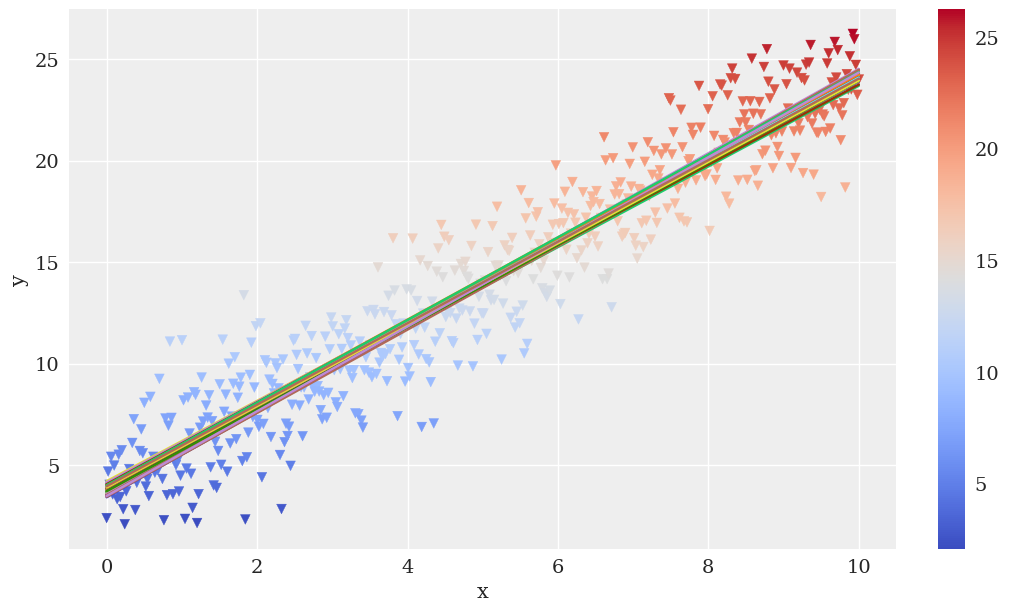

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace.posterior['alpha'][0].values)):
    plt.plot(x, trace.posterior['alpha'][0].values[i] + trace.posterior['beta'][0].values[i] * x)   
# plt.savefig('../../images/ch13/stat_17.png');

In [ ]:
%%time
with pm.Model() as model:
    # model
    alpha = pm.Normal('alpha', mu=0, sigma=20)  # Defines the priors
    beta = pm.Normal('beta', mu=0, sigma=10)  # Defines the priors 
    sigma = pm.Uniform('sigma', lower=0, upper=10)  # Defines the priors
    y_est = alpha + beta * x    # Specifies the linear regression
    likelihood = pm.Normal('y', mu=y_est, sigma=sigma,
                           observed=y)   # Defines the likelihood.
    
    # inference
    trace = pm.sample()  #  Instantiates the MCMC algorithm.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 72 seconds.
The acceptance probability does not match the target. It is 0.8812, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: total: 6.41 s
Wall time: 1min 41s


In [ ]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.772,0.179,3.417,4.080,0.007,0.005,749.0,790.0,1.0
beta,2.035,0.031,1.980,2.095,0.001,0.001,718.0,743.0,1.0
sigma,2.009,0.065,1.894,2.134,0.002,0.001,1225.0,786.0,1.0


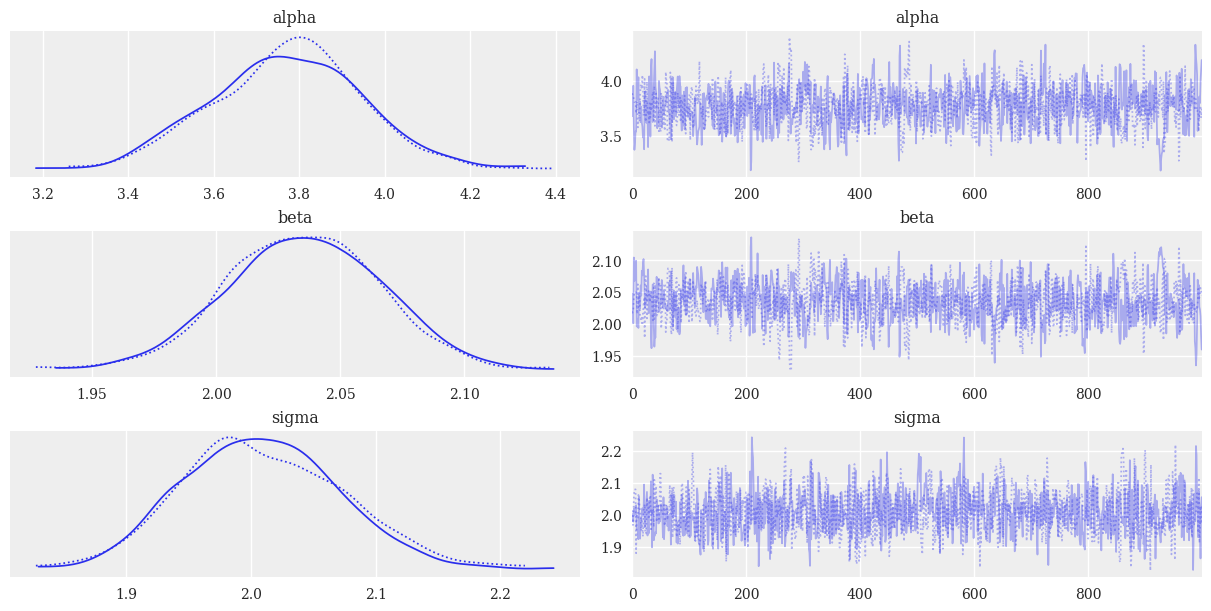

In [ ]:
az.plot_trace(trace);
plt.show()
# plt.savefig('../../images/ch13/stat_16.png');

### Two Financial Instruments

In [9]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [10]:
data = raw[['GDX', 'GLD']].dropna()

In [11]:
data

,GDX,GLD
Date,,
2010-01-04,47.71,109.80
2010-01-05,48.17,109.70
2010-01-06,49.34,111.51
2010-01-07,49.10,110.82
2010-01-08,49.84,111.37
...,...,...
2018-06-25,22.01,119.89
2018-06-26,21.95,119.26
2018-06-27,21.81,118.58


In [12]:
data.iloc[0]

GDX     47.71
GLD    109.80
Name: 2010-01-04 00:00:00, dtype: float64

In [13]:
data = data / data.iloc[0]  

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2138 entries, 2010-01-04 to 2018-06-29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDX     2138 non-null   float64
 1   GLD     2138 non-null   float64
dtypes: float64(2)
memory usage: 50.1 KB


In [15]:
data.iloc[-1] / data.iloc[0] - 1  

GDX   -0.532383
GLD    0.080601
dtype: float64

In [16]:
data.corr()  

,GDX,GLD
GDX,1.00000,0.71539
GLD,0.71539,1.00000


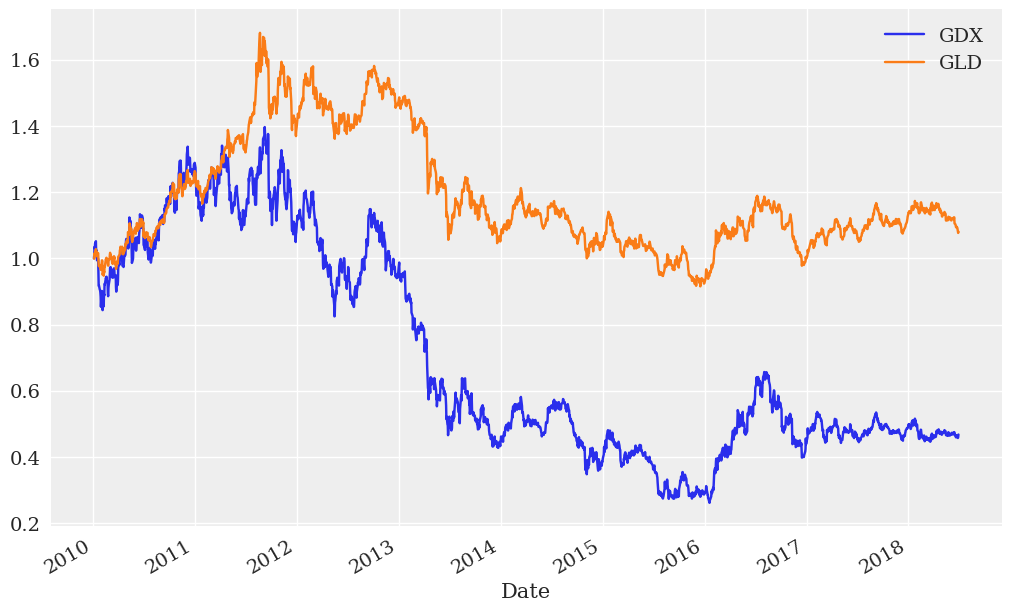

In [17]:
data.plot(figsize=(10, 6));
# plt.savefig('../../images/ch13/stat_18.png');

In [ ]:
data.index[:3]

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06'], dtype='datetime64[ns]', name='Date', freq=None)

In [24]:
mpl_dates = mpl.dates.date2num(data.index.to_pydatetime())  
mpl_dates[:3]

array([733776., 733777., 733778.])

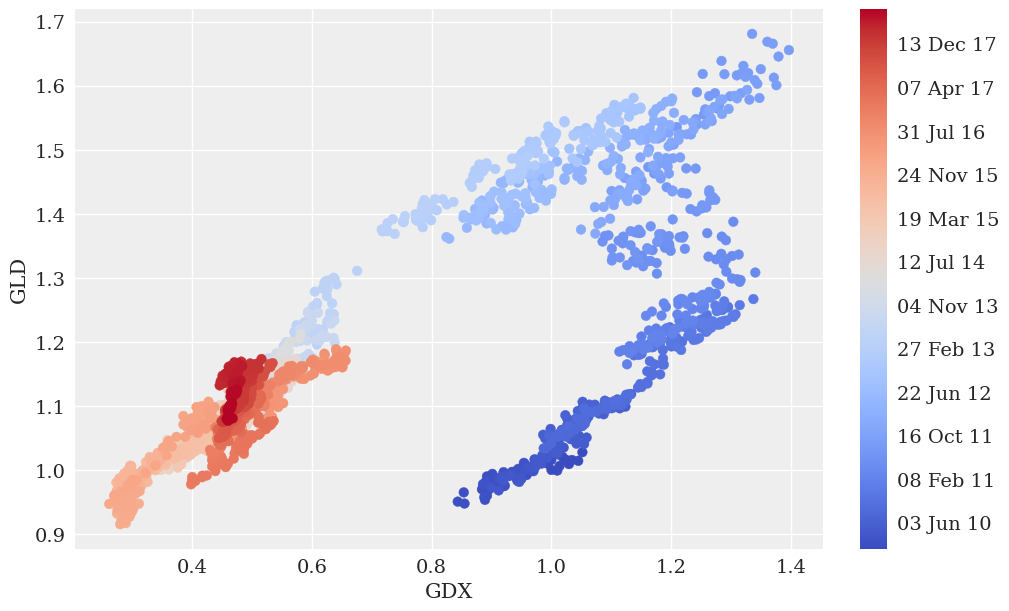

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates,
            marker='o', cmap='coolwarm')
plt.xlabel('GDX')
plt.ylabel('GLD')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
             format=mpl.dates.DateFormatter('%d %b %y'));  
# plt.savefig('../../images/ch13/stat_19.png');

In [ ]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=20)
    beta = pm.Normal('beta', mu=0, sigma=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    y_est = alpha + beta * data['GDX'].values
    
    likelihood = pm.Normal('GLD', mu=y_est, sigma=sigma,
                           observed=data['GLD'].values)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(250, tune=2000, start=start,
                      progressbar=True)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 2_000 tune and 250 draw iterations (4_000 + 500 draws total) took 159 seconds.


In [ ]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.914,0.006,0.903,0.925,0.0,0.0,280.0,265.0,1.01
beta,0.386,0.008,0.371,0.400,0.0,0.0,259.0,312.0,1.01
sigma,0.120,0.002,0.116,0.123,0.0,0.0,213.0,256.0,1.02


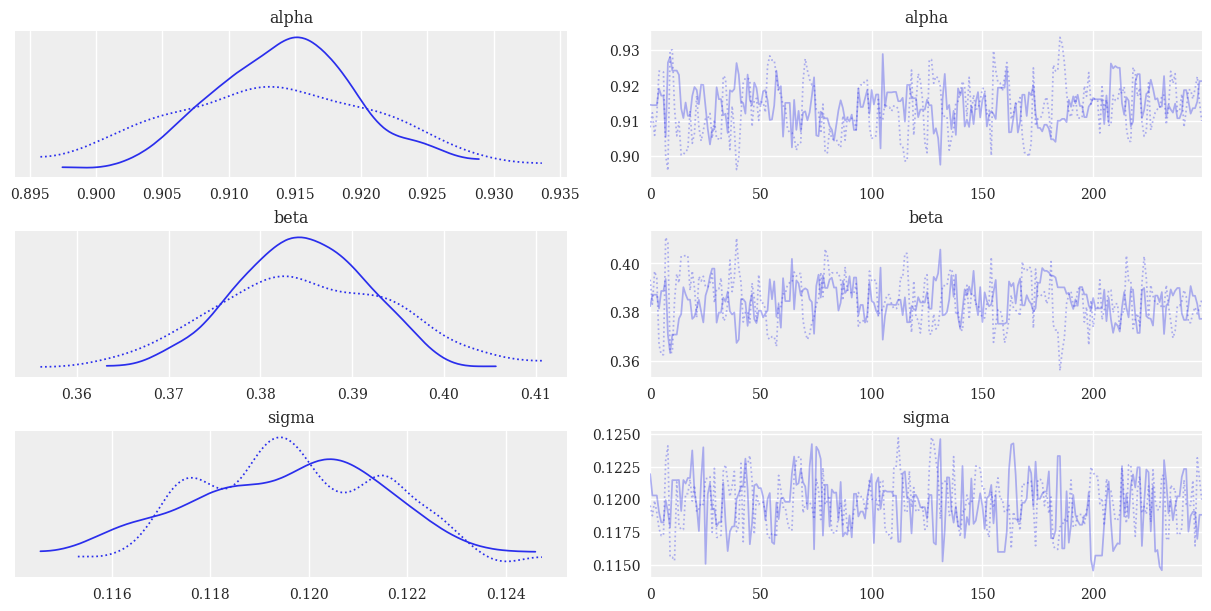

In [ ]:
fig = az.plot_trace(trace)
# plt.savefig('../../images/ch13/stat_20.png');

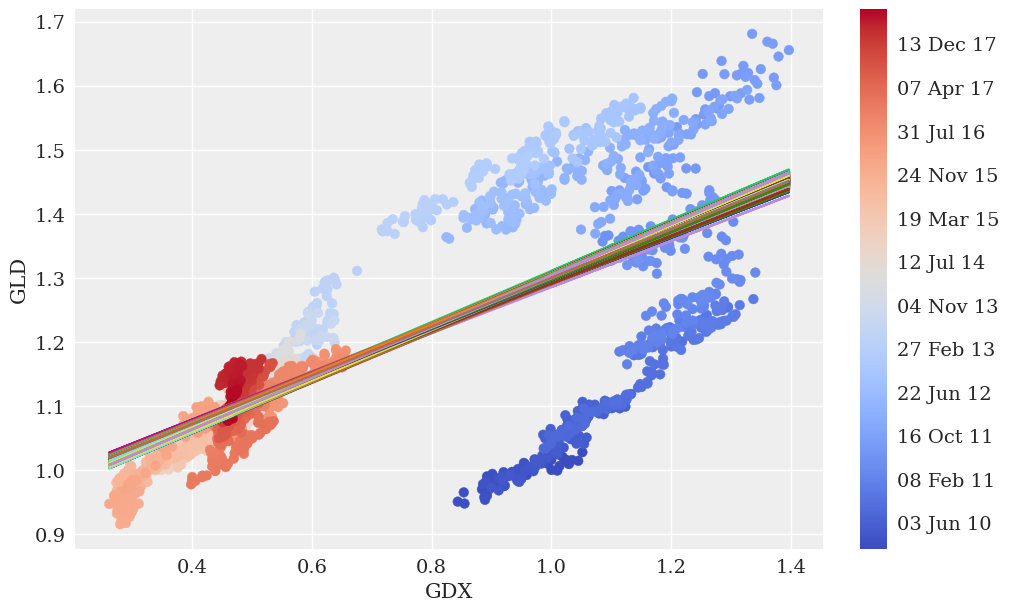

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates,
            marker='o', cmap='coolwarm')
plt.xlabel('GDX')
plt.ylabel('GLD')
for i in range(len(trace.posterior['alpha'].values.flatten())):
    plt.plot(data['GDX'], trace.posterior['alpha'].values.flatten()[i] + trace.posterior['beta'].values.flatten()[i] * data['GDX'])
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
             format=mpl.dates.DateFormatter('%d %b %y'));
# plt.savefig('../../images/ch13/stat_21.png');

### Updating Estimates over Time

In [6]:
from pymc3.distributions.timeseries import GaussianRandomWalk

In [7]:
subsample_alpha = 50
subsample_beta = 50

In [18]:
shape=int(len(data) / subsample_alpha)
shape

42

In [19]:
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = pm.Exponential('sig_alpha', 1. / .02, testval=.1)  
    sigma_beta = pm.Exponential('sig_beta', 1. / .02, testval=.1)  
    alpha = GaussianRandomWalk('alpha', sigma_alpha ** -2,
                        shape=int(len(data) / subsample_alpha))  
    beta = GaussianRandomWalk('beta', sigma_beta ** -2,
                        shape=int(len(data) / subsample_beta))  
    alpha_r = np.repeat(alpha, subsample_alpha)  
    beta_r = np.repeat(beta, subsample_beta)  
    regression = alpha_r + beta_r * data['GDX'].values[:2100]  
    sd = pm.Uniform('sd', 0, 20)  
    likelihood = pm.Normal('GLD', mu=regression, sd=sd,
                           observed=data['GLD'].values[:2100])  

In [20]:
%%time
with model_randomwalk:
    trace_rw = pm.sample(cores=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, beta, alpha, sig_beta, sig_alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 215 seconds.


CPU times: user 3min 40s, sys: 2.86 s, total: 3min 43s
Wall time: 4min 34s


In [21]:
pm.summary(trace_rw).head()

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.671,0.042,0.591,0.747,0.001,0.000,3884.0,1226.0,1.01
alpha[1],0.422,0.040,0.350,0.499,0.001,0.000,4653.0,1634.0,1.00
alpha[2],0.457,0.061,0.331,0.561,0.001,0.001,5320.0,978.0,1.00
alpha[3],0.269,0.044,0.181,0.343,0.001,0.001,3674.0,1377.0,1.00
alpha[4],0.651,0.052,0.550,0.742,0.001,0.001,4680.0,1567.0,1.00


In [22]:
sh = np.shape(trace_rw['alpha']) 
sh

(2000, 42)

In [31]:
part_dates = np.linspace(min(mpl_dates), max(mpl_dates), sh[1])    

In [35]:
index = [dt.datetime.fromordinal(int(date)) for date in part_dates]
index  

[datetime.datetime(2010, 1, 4, 0, 0),
 datetime.datetime(2010, 3, 20, 0, 0),
 datetime.datetime(2010, 6, 4, 0, 0),
 datetime.datetime(2010, 8, 18, 0, 0),
 datetime.datetime(2010, 11, 2, 0, 0),
 datetime.datetime(2011, 1, 16, 0, 0),
 datetime.datetime(2011, 4, 2, 0, 0),
 datetime.datetime(2011, 6, 16, 0, 0),
 datetime.datetime(2011, 8, 31, 0, 0),
 datetime.datetime(2011, 11, 15, 0, 0),
 datetime.datetime(2012, 1, 29, 0, 0),
 datetime.datetime(2012, 4, 14, 0, 0),
 datetime.datetime(2012, 6, 28, 0, 0),
 datetime.datetime(2012, 9, 12, 0, 0),
 datetime.datetime(2012, 11, 26, 0, 0),
 datetime.datetime(2013, 2, 10, 0, 0),
 datetime.datetime(2013, 4, 26, 0, 0),
 datetime.datetime(2013, 7, 11, 0, 0),
 datetime.datetime(2013, 9, 25, 0, 0),
 datetime.datetime(2013, 12, 9, 0, 0),
 datetime.datetime(2014, 2, 23, 0, 0),
 datetime.datetime(2014, 5, 9, 0, 0),
 datetime.datetime(2014, 7, 24, 0, 0),
 datetime.datetime(2014, 10, 7, 0, 0),
 datetime.datetime(2014, 12, 22, 0, 0),
 datetime.datetime(2015, 3

In [36]:
alpha = {'alpha_%i' % i: v for i, v in enumerate(trace_rw['alpha']) if i < 20} 

In [38]:
beta = {'beta_%i' % i: v for i, v in enumerate(trace_rw['beta']) if i < 20}  

In [39]:
df_alpha = pd.DataFrame(alpha, index=index)  

In [40]:
df_beta = pd.DataFrame(beta, index=index)  

In [42]:
df_beta.head()

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,beta_14,beta_15,beta_16,beta_17,beta_18,beta_19
2010-01-04,0.416856,0.307908,0.296914,0.325015,0.362843,0.300080,0.281493,0.384562,0.299767,0.385755,0.312793,0.252114,0.273288,0.295118,0.315836,0.351603,0.315897,0.311422,0.365409,0.344299
2010-03-20,0.550236,0.654594,0.632488,0.593484,0.611036,0.640739,0.620816,0.568395,0.664117,0.551068,0.618326,0.602198,0.575435,0.559969,0.590712,0.605992,0.629589,0.670323,0.597675,0.561697
2010-06-04,0.541265,0.611988,0.649503,0.549324,0.624732,0.591824,0.649893,0.444753,0.721387,0.477408,0.633759,0.582009,0.621914,0.613691,0.587190,0.605255,0.619170,0.638653,0.485142,0.648694
2010-08-18,0.794871,0.738408,0.704746,0.763816,0.761121,0.808394,0.805048,0.776098,0.755729,0.777968,0.782546,0.775220,0.767429,0.792680,0.746808,0.791178,0.818796,0.762759,0.702562,0.795227
2010-11-02,0.484432,0.409423,0.511582,0.451477,0.454014,0.504179,0.490486,0.390589,0.526641,0.403647,0.459887,0.500447,0.400319,0.481610,0.452102,0.446052,0.468137,0.473225,0.456635,0.504196


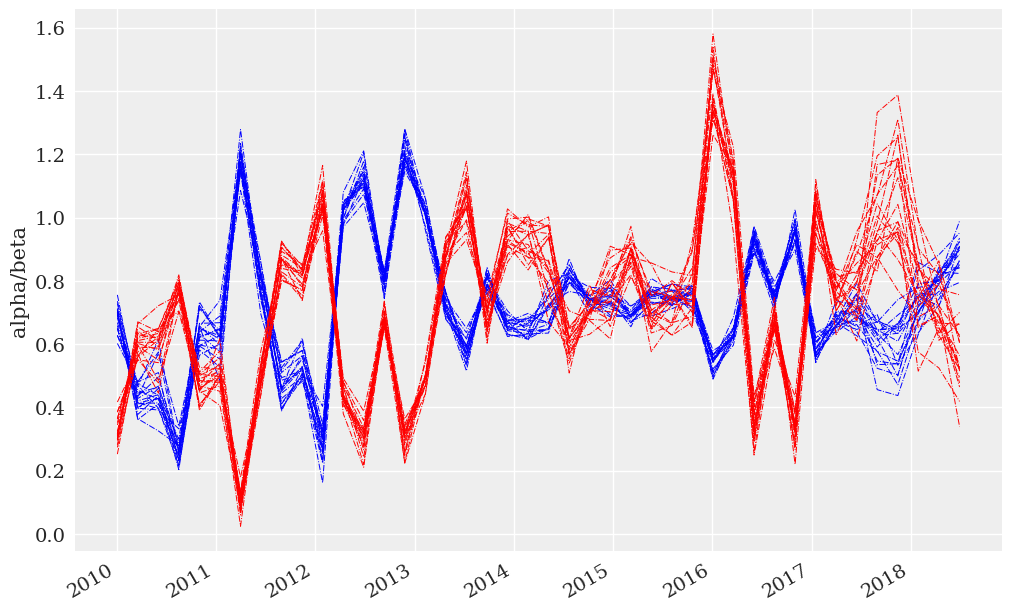

In [43]:
ax = df_alpha.plot(color='b', style='-.', legend=False,
                   lw=0.7, figsize=(10, 6))
df_beta.plot(color='r', style='-.', legend=False,
             lw=0.7, ax=ax)
plt.ylabel('alpha/beta');
# plt.savefig('../../images/ch13/stat_22.png');

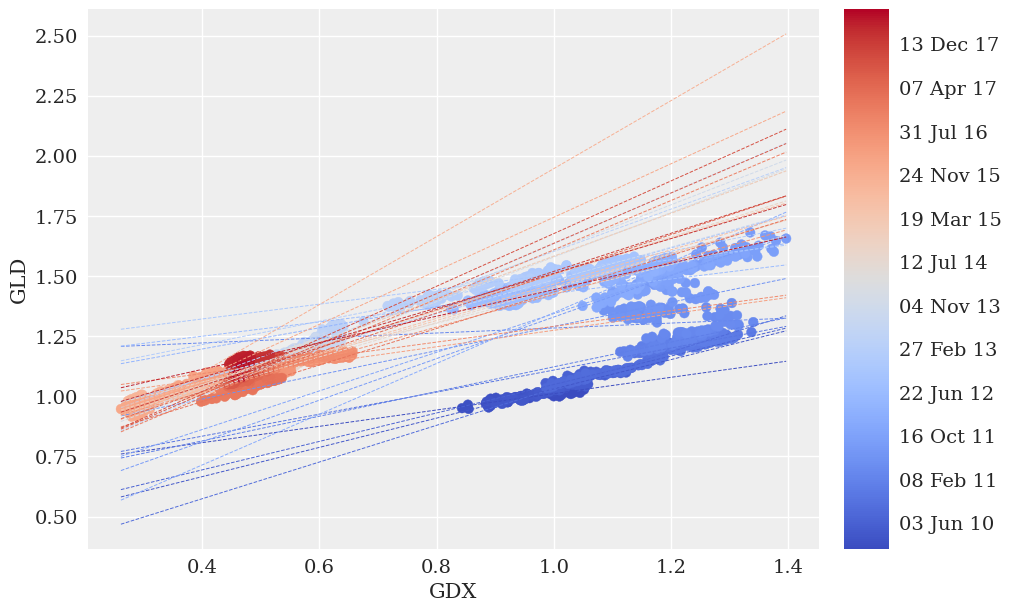

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GDX'], data['GLD'], c=mpl_dates,
            marker='o', cmap='coolwarm')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
             format=mpl.dates.DateFormatter('%d %b %y'))
plt.xlabel('GDX')
plt.ylabel('GLD')
x = np.linspace(min(data['GDX']), max(data['GDX']))
for i in range(sh[1]):  
    alpha_rw = np.mean(trace_rw['alpha'].T[i])
    beta_rw = np.mean(trace_rw['beta'].T[i])
    plt.plot(x, alpha_rw + beta_rw * x, '--', lw=0.7,
            color=plt.cm.coolwarm(i / sh[1]))
# plt.savefig('../../images/ch13/stat_23.png');

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>